# PRETRAIN FROM PERSONALLY TRAINED MODEL
## FastAI Cassava Root Disease Classification

In [1]:

## PREVIOUS BEST WITH ACC = 0.87
# RUN_NAME_OF_MODEL_TO_LOAD = '20210210-1221 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=40 bs=8 res=480'
# EPOCH_TO_LOAD = 1


In [2]:
RUN_NAME_OF_MODEL_TO_LOAD = '20210216-0426 - arch=densenetblur121d - samples=1800 frozen=1 epochs=60 bs=32 res=400'
RUN_NAME_OF_MODEL_TO_LOAD_last = '20210216-1811 - arch=densenetblur121d - samples=1800 frozen=1 epochs=60 bs=32 res=300'
RUN_NAME_OF_MODEL_TO_LOAD = '20210217-0055 - arch=densenetblur121d - samples=4000 frozen=1 epochs=60 bs=32 res=300'




# EPOCH_TO_LOAD = 9

<br>
<br>

In [3]:
from datetime import datetime
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import fastai
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from string import ascii_uppercase
import numpy as np
import operator
import glob

import torch
from torch import nn as nn
from torch.nn import functional as F

import gc


%matplotlib inline

# %matplotlib widget

plt.rcParams['figure.figsize'] = [9, 5]
plt.rcParams['figure.dpi'] = 120
plt.style.use('dark_background')


ARCH = 'densenetblur121d'  # resnet101

CHOSEN_SAMPLE_SIZE = 3000  #1800  # use this to control per-category sample sizes # 1000  # deprecated but not removed
# TEST_SET_SIZE = round(CHOSEN_SAMPLE_SIZE * 0.1)  # number of images per category to put in the test set
FROZEN_EPOCHS = 1  # 1
EPOCHS = 60  # 4
BATCH_SIZE = 32  # 16
# RESOLUTION = round(380 * 1.2)  # 300
RESOLUTION=300
PRETRAINED_FLAG = True  # actually False - just to make sure we train a few times before attempting to find LR

# data = ''
# rn_addon = f'_data={data}'

time = datetime.today().strftime("%Y%m%d-%H%M")

# RUN_NAME = f'{time} - arch={ARCH.__name__} - samples={CHOSEN_SAMPLE_SIZE} frozen={FROZEN_EPOCHS} epochs={EPOCHS} bs={BATCH_SIZE} res={RESOLUTION}'
RUN_NAME = f'{time} - arch={ARCH} - samples={CHOSEN_SAMPLE_SIZE} frozen={FROZEN_EPOCHS} epochs={EPOCHS} bs={BATCH_SIZE} res={RESOLUTION}'

print(f"RUN_NAME = '{RUN_NAME}'")


RUN_NAME = '20210217-0231 - arch=densenetblur121d - samples=3000 frozen=1 epochs=60 bs=32 res=300'


In [4]:
import torch
print('CUDA available: '.ljust(28), torch.cuda.is_available())
print('CUDA device count: '.ljust(28), torch.cuda.device_count())

current_device = torch.cuda.current_device()
print('Current CUDA Device index: '.ljust(28), current_device)
# torch.cuda.device(current_device)
print('Current CUDA Device: '.ljust(28), torch.cuda.get_device_name(current_device))
print()
# print('CUDA available: '.ljust(24), torch.cuda.is_available())
print(f'fastai version:              {fastai.__version__}')
# print(f'fastcore version:            {fastcore.__version__}')
# print(f'fastbook version:            {fastbook.__version__}')
print(f'cuda version:                {torch.version.cuda}')
print(f'torch version:               {torch.__version__}')
# print(f'python version:              {python_version()}')

CUDA available:              True
CUDA device count:           1
Current CUDA Device index:   0
Current CUDA Device:         GeForce RTX 2070 SUPER

fastai version:              2.2.5
cuda version:                11.0
torch version:               1.7.0


<br>
<br>

## Utility Functions to use timm models on FastAI

written by Zach Mueller / walkwithfastai.com



In [5]:
from timm import create_model
from fastai.vision.learner import _update_first_layer

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='', memory_efficient=True)
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
        
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=False, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model


def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

import kornia
def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = kornia.contrib.MaxBlurPool2d(3, True)
            model._modules[name] = layer_new

    return model


def convert_act_cls(model, layer_type_old, layer_type_new):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_act_cls(module, layer_type_old, layer_type_new)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = layer_type_new
            model._modules[name] = layer_new

    return model

<br>
<br>

## Memory efficient implementation of Swish and Mish from Ross Wightman

In [6]:
class SwishAutoFn(torch.autograd.Function):
    """Swish - Described in: https://arxiv.org/abs/1710.05941
    Memory efficient variant from:
     https://medium.com/the-artificial-impostor/more-memory-efficient-swish-activation-function-e07c22c12a76
    """
    @staticmethod
    def forward(ctx, x):
        result = x.mul(torch.sigmoid(x))
        ctx.save_for_backward(x)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_tensors[0]
        x_sigmoid = torch.sigmoid(x)
        return grad_output.mul(x_sigmoid * (1 + x * (1 - x_sigmoid)))


def swish_auto(x, inplace=False):
    # inplace ignored
    return SwishAutoFn.apply(x)


class SwishAuto(nn.Module):
    def __init__(self, inplace: bool = True):
        super(SwishAuto, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return SwishAutoFn.apply(x)




class MishAutoFn(torch.autograd.Function):
    """Mish: A Self Regularized Non-Monotonic Neural Activation Function - https://arxiv.org/abs/1908.08681
    Experimental memory-efficient variant
    """

    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        y = x.mul(torch.tanh(F.softplus(x)))  # x * tanh(ln(1 + exp(x)))
        return y

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_tensors[0]
        x_sigmoid = torch.sigmoid(x)
        x_tanh_sp = F.softplus(x).tanh()
        return grad_output.mul(x_tanh_sp + x * x_sigmoid * (1 - x_tanh_sp * x_tanh_sp))


def mish_auto(x, inplace=False):
    # inplace ignored
    return MishAutoFn.apply(x)


class MishAuto(nn.Module):
    def __init__(self, inplace: bool = True):
        super(MishAuto, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return MishAutoFn.apply(x)

## More by zach via Abhishek Tez - augmentations 

In [7]:
import albumentations as A

class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)
    
    

def get_train_aug(): return A.Compose([
            A.RandomResizedCrop(RESOLUTION,RESOLUTION, scale=(0.2, 1)),
            A.Transpose(p=0.7),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.ShiftScaleRotate(p=0.7),
            A.HueSaturationValue(
                hue_shift_limit=0.3, 
                sat_shift_limit=0.3, 
                val_shift_limit=0.3, 
                p=0.7
            ),
            A.RandomBrightnessContrast(
                brightness_limit=(-0.2,0.2), 
                contrast_limit=(-0.2, 0.2), 
                p=0.7
            ),
            A.CoarseDropout(p=0.8, max_holes=20),
            A.Cutout(p=0.8, max_h_size=12, max_w_size=12),
            A.OneOf([
                    A.OpticalDistortion(p=0.3),
                    A.GridDistortion(p=.1),
                    A.IAAPiecewiseAffine(p=0.3),
                    ], p=0.2),
            A.Sharpen(p=0.3, alpha=(0.1,0.3), lightness=(0.3, 0.9)),
            A.OneOf([
                A.IAAAdditiveGaussianNoise(p=1.0),
                A.GaussNoise(p=1.0),
                A.MotionBlur(always_apply=False, p=1.0, blur_limit=(3, 3))
                ], p=0.3),
            ], p=1.0)



def get_valid_aug(): return A.Compose([
    A.OneOf([
        A.CenterCrop(RESOLUTION,RESOLUTION, always_apply=True),
#         A.Resize(RESOLUTION, RESOLUTION, p=1.0),
        A.RandomResizedCrop(RESOLUTION,RESOLUTION, scale=(0.2, 0.8), always_apply=True),
        ], p=1.0),
#     A.HueSaturationValue(
#         hue_shift_limit=0.2, 
#         sat_shift_limit=0.2, 
#         val_shift_limit=0.2, 
#         p=0.6
#         ),
#     A.RandomBrightnessContrast(
#         brightness_limit=(-0.1,0.1), 
#         contrast_limit=(-0.1, 0.1), 
#         p=0.6
#         ),
    A.Sharpen(p=0.7, alpha=(0.1, 0.3), lightness=(0.3, 0.9))
    ], p=1.0)


<br>
<br>

### Check for Imbalance

In [8]:
classes = ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']

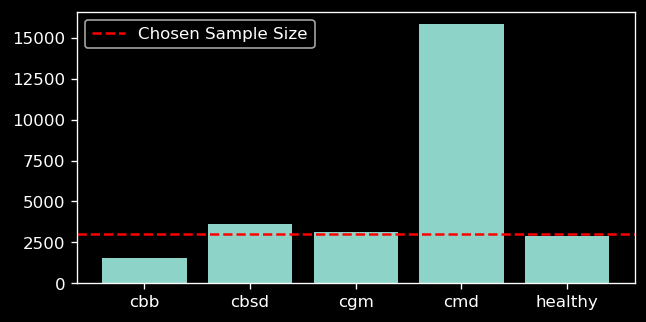

In [9]:
path = '../data/train_images_sorted_extra'

img_flist = {}
img_quants = {}
all_files = []

for c in classes:
    files = get_image_files(f'{path}/{c}')
    img_flist[c] = list(files)
    img_quants[c] = len(files)
    all_files.extend(files)

minqc = min(img_quants, key=img_quants.get)

sample_size = CHOSEN_SAMPLE_SIZE #round(img_quants[minqc] * 5)  # oversample the lowest class quantity


plt.figure(figsize=(6,3))
plt.bar(img_quants.keys(), img_quants.values())  
plt.axhline(sample_size, ls='--', color='red', label='Chosen Sample Size')
plt.legend()
plt.show()
        

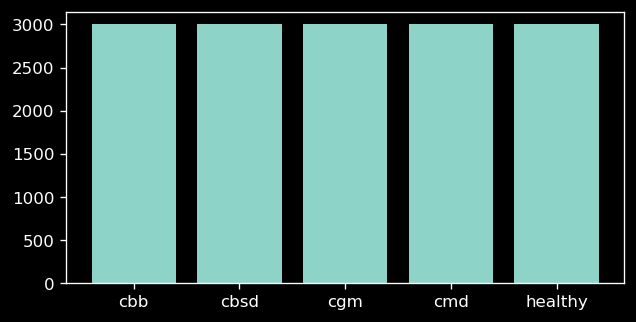

In [10]:

for c in classes:
    if len(img_flist[c]) < sample_size:
#         all_covid = img_flist[c].copy()
        img_flist[c] = np.append(img_flist[c], np.random.choice(img_flist[c], sample_size - len(img_flist[c]), replace=True))
    else:
        img_flist[c] = np.random.choice(img_flist[c], sample_size, replace=False)  # without replacement

    # boost the weak class
#     if c == 'healthy':
#         img_flist[c] = np.append(img_flist[c], np.random.choice(img_flist[c], round(sample_size * 0.5), replace=False))
    # hide the overeager class
#     if c == 'healthy':
#         img_flist[c] = np.random.choice(img_flist[c], round(sample_size * 0.95), replace=False)
        
    # increase data for augmentations   
#     img_flist[c] = np.append(img_flist[c], np.random.choice(img_flist[c], len(img_flist[c]), replace=False))  
plt.figure(figsize=(6,3))
plt.bar(img_flist.keys(), [len(l) for l in img_flist.values()])
plt.show()

In [11]:
test_flist = {}
test_size = round(0.1 * sample_size)

for c in classes:
    img_flist[c] = np.random.choice(img_flist[c], len(img_flist[c]), replace=False)  # shuffle
    test_flist[c] = img_flist[c][0:test_size]
    img_flist[c] = img_flist[c][test_size:]
#     img_flist[c] = [f for f in img_flist[c] if f not in test_flist[c]]

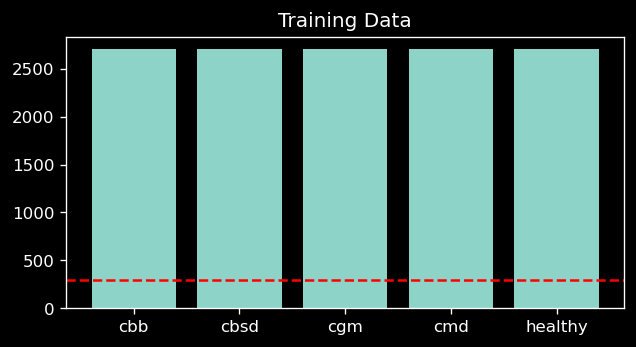

In [12]:
plt.figure(figsize=(6,3))
plt.title('Training Data')
plt.bar(img_flist.keys(), [len(l) for l in img_flist.values()])
plt.axhline(test_size, ls='--', color='red')
plt.show()

plt.figure(figsize=(6,3))
plt.title('Validation Data')
plt.bar(test_flist.keys(), [len(l) for l in test_flist.values()])
plt.show()
                 

<br>
<br>

### Create the DataLoaders

In [13]:
with open(f"INACCFLIST_{RUN_NAME_OF_MODEL_TO_LOAD}.p", "rb") as pfile:
    inacc_flist = pickle.load(pfile)

In [14]:
def get_fnames(path):
    retlist = []
    
    for l in img_flist.values():
        for f in l:
            retlist.append(f)
            
#     retlist.extend(np.random.choice(inacc_flist, 1000, replace=True))
    retlist.extend(inacc_flist)  # @TODO REMOVE INACC CODE
            
    return random.sample(retlist, len(retlist))


item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())


# batch_tfms = [ *aug_transforms(size=round(RESOLUTION * 1), do_flip=True, batch=True, max_zoom=1.7, mult=2.4), Normalize.from_stats(*imagenet_stats) ]
# batch_tfms = [ *aug_transforms(size=RESOLUTION, do_flip=True, batch=False, max_lighting=0.7,
#                                max_rotate=30, max_zoom=2.5, mult=2.0, max_warp=0.1), 
#               Normalize.from_stats(*imagenet_stats) ]

batch_tfms = [Normalize.from_stats(*imagenet_stats)]


img_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_fnames, 
    splitter=RandomSplitter(valid_pct=0.28, seed=42),
    get_y=parent_label,
#     item_tfms=RandomResizedCrop(RESOLUTION, method='bilinear') , batch_tfms=batch_tfms)
    item_tfms=item_tfms , batch_tfms=batch_tfms)

dls = img_db.dataloaders(path, batch_size=BATCH_SIZE)

<br>

### Verify the Training and Validation Batches

examples from the training set


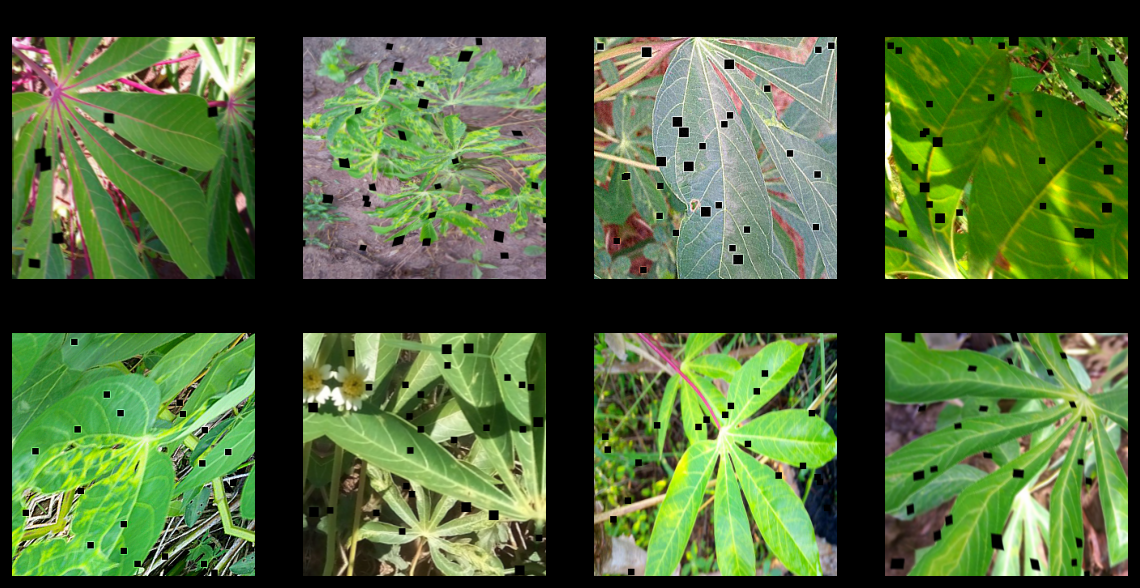

In [15]:
print('examples from the training set')
dls.train.show_batch(max_n=8, nrows=2)

In [16]:
print('\nexamples from the validation set')
dls.valid.show_batch(max_n=8, nrows=2)


examples from the validation set


<br>
<br>

## Create our Callbacks

In [17]:
# Eary stopping callback
early_stop_cb = EarlyStoppingCallback(monitor='error_rate', min_delta=0.0001, patience=5)

# Save the current model's weights every epoch
save_cb = SaveModelCallback(fname=RUN_NAME, with_opt=True)

# Reduce the Learning Rate if valid_loss flatlines
reduceLR_cb = ReduceLROnPlateau(monitor='valid_loss', min_delta=0.01, min_lr=1e-8, patience=1, factor=4, reset_on_fit=False)

# Mixup callback for regularization
# mixup_cb = MixUp(alpha=0.3)
mixup_cb = None

# Cutmix callback for regularization
cutmix_cb = CutMix()
# cutmix_cb = None

# Gradient Accumulation
# gradacc_cb =  GradientAccumulation(n_acc=16)
gradacc_cb =  GradientAccumulation(n_acc=128)


# List of callbacks to be used later
cbs = [save_cb, GradientClip, gradacc_cb, ShowGraphCallback()]  # , reduceLR_cb

if mixup_cb != None:
    cbs.insert(0, mixup_cb)
    
if cutmix_cb != None:
    cbs.insert(0, cutmix_cb)




print('\nAll Callbacks: ', cbs)


All Callbacks:  [CutMix, SaveModelCallback, <class 'fastai.callback.training.GradientClip'>, GradientAccumulation, ShowGraphCallback]


### Visualize the effect of CutMix


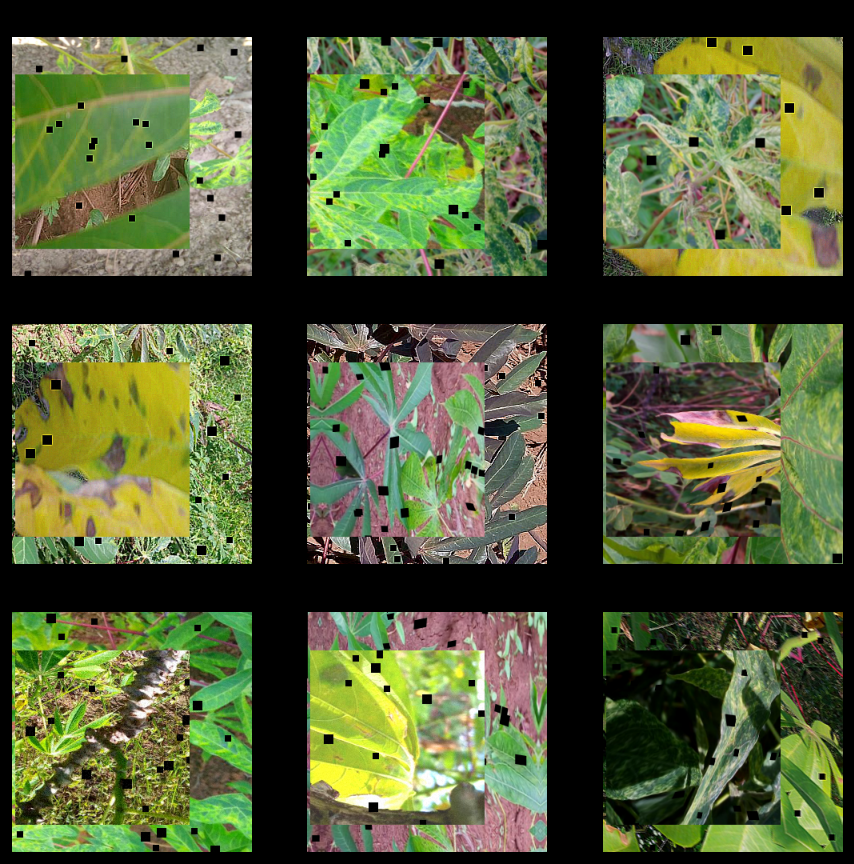

In [18]:
if cutmix_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(cutmix_cb.x,cutmix_cb.y), ctxs=axs.flatten())
    
else: print('\n CutMix was not selected.')

<br>

### Visualize the Effect of MixUp

MixUp creates a linear interpolation between the target data and another datapoint.  In images, it shows up as ghostly figures.  The technique has been shown to be a good to decrease the liklihood of overfitting.

In [19]:
if mixup_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(mixup_cb.x,mixup_cb.y), ctxs=axs.flatten())

else: print('\n MixUp was not selected.')


 MixUp was not selected.


In [38]:
# learn = cnn_learner(dls, ARCH , 
#                     pretrained=PRETRAINED_FLAG, wd=1e-4, opt_func=ranger,
#                     loss_func=LabelSmoothingCrossEntropyFlat(), 
#                     cbs = cbs, metrics=[error_rate, accuracy])

# from wwf.vision.timm import *
import timm
learn = timm_learner(dls, 
                     ARCH,
                     opt_func=ranger,
                     loss_func=CrossEntropyLossFlat(),
                     cbs=cbs, 
                     pretrained=PRETRAINED_FLAG,
                     metrics = [accuracy])  #.to_fp16()



In [39]:
# Add custom weights to learn

# learn = load_learner(f'../models/{RUN_NAME_OF_MODEL_TO_LOAD}.pkl', cpu=False)
# load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}_{EPOCH_TO_LOAD}.pth', learn, opt=ranger, with_opt=False)

learn = convert_MP_to_blurMP(learn, nn.MaxPool2d)  # doesn't exist!
learn.model = convert_act_cls(learn.model, nn.ReLU, MishAuto())  # very expensive so we only use it on the last layers
learn.model = convert_act_cls(learn.model, nn.SiLU, SwishAuto())  # replace with a lower memory version


# learn = learn.to_fp16()  # convert to 16bit

In [40]:
display(learn.loss_func, learn.opt_func, learn.cbs) #, '-------------------------------------', learn.model)  # Checkpoint

FlattenedLoss of CrossEntropyLoss()

<function fastai.optimizer.ranger(p, lr, mom=0.95, wd=0.01, eps=1e-06, sqr_mom=0.99, beta=0.0, decouple_wd=True)>

(#8) [TrainEvalCallback,Recorder,ProgressCallback,CutMix,SaveModelCallback,GradientClip,GradientAccumulation,ShowGraphCallback]

In [41]:
learn.model[1]

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): MishAuto()
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=5, bias=False)
)

In [42]:
# # RUN_NAME_OF_MODEL_TO_LOAD = '20210211-0115 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=15 bs=12 res=460'
# EPOCH_TO_LOAD = 7

load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}.pth', learn, opt=ranger, with_opt=True)



<br>
<br>
<br>
<br>

# ------------------ RUN TO HERE -------------------

<br>
<br>
<br>

## Find a Good Learning Rate to Start With

In [ ]:
LR_DIV = 14e0  # Shift the lr_min left by this amount.  Adjust as necessary
lr_min = 0.002  # just a default

In [ ]:
# from apex.fp16_utils import convert_network
# learn.model = convert_network(learn.model, torch.float16)

In [ ]:
# learn = learn.to_fp16()

In [ ]:
if PRETRAINED_FLAG == True:
    learn.freeze()
    lr_min,lr_steep = learn.lr_find()
    plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
    plt.axvline(lr_min/LR_DIV, ls='--', color='yellow', label=f'lr_min / {LR_DIV}={round(lr_min/LR_DIV,6)}')
    plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
    plt.legend()
    plt.show()

    print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}, (Mim/10)/{LR_DIV}: {lr_min/LR_DIV}")

<br>
<br>

# Pick a Good Initial Learning Rate

In [ ]:
# LR_CHOICE = lr_min/LR_DIV
# LR_CHOICE = lr_steep
LR_CHOICE = 9e-3
# LR_CHOICE = 2e-4
# LR_CHOICE = 7e-2
# LR_CHOICE=1e-3

<br>
<br>

<br>
<br>

# Training the Model

<br>

## Fit the last layers, unfreeze, fit the whole net, with a decent initial LR, all in one go.



In [ ]:
if PRETRAINED_FLAG:
    print(f'FROZEN_EPOCHS:  {FROZEN_EPOCHS}')
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE}\n\n')

In [ ]:
if PRETRAINED_FLAG:
    learn.fit_flat_cos(FROZEN_EPOCHS, LR_CHOICE, pct_start=0.99, wd=0.1, reset_opt=True)
#     fit_hump(learn, 1, lr_max=LR_CHOICE, reset_opt=True)
#     learn.fit_one_cycle(FROZEN_EPOCHS, slice(LR_CHOICE), wd=0.1)

    print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
    torch.cuda.reset_max_memory_allocated()

## Manually set up the unfrozen runs

In [25]:
learn.unfreeze()

/home/frank/miniconda3/envs/learn/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


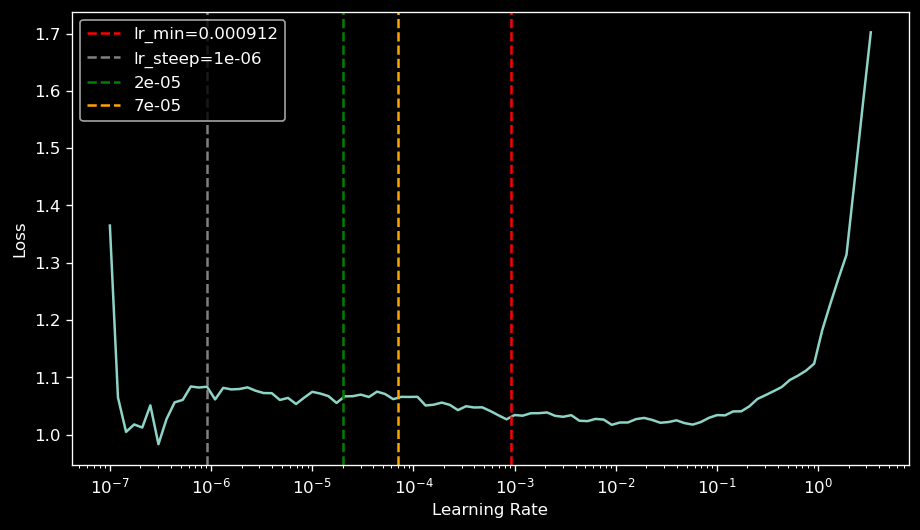

In [26]:
lr_min,lr_steep = learn.lr_find()
plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
# plt.axvline(LR_CHOICE/2, ls='--', color='yellow', label=f'LR_CHOICE/2={round(LR_CHOICE/2,6)}')
plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
plt.axvline(2e-5, ls='--', color='green', label=f'{round(2e-5,6)}')
plt.axvline(7e-5, ls='--', color='orange', label=f'{round(7e-5,6)}')

plt.legend()
plt.show()

In [27]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")  #, LR_CHOICE/2: {LR_CHOICE / 2}")

Minimum/10: 9.12e-04, steepest point: 9.12e-07


## Pick a new Learning Rate

In [28]:
# LR_CHOICE_UNFROZ = 9e-3
# LR_CHOICE_UNFROZ = 3e-3
# LR_CHOICE_UNFROZ = 4e-3
# LR_CHOICE_UNFROZ = 6e-3
LR_CHOICE_UNFROZ = 5e-4



### Train

In [29]:
EPOCHS = 20

In [30]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

EPOCHS:         20
Learning Rate:  0.0005




Better model found at epoch 0 with valid_loss value: 0.6443899273872375.


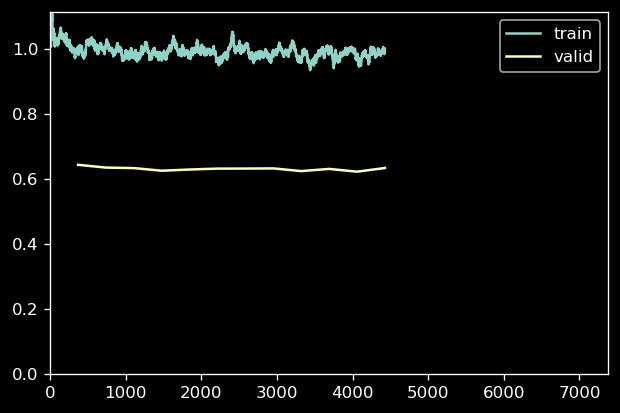

Better model found at epoch 1 with valid_loss value: 0.6358319520950317.
Better model found at epoch 2 with valid_loss value: 0.6342499256134033.
Better model found at epoch 3 with valid_loss value: 0.6262159943580627.
Better model found at epoch 8 with valid_loss value: 0.6250789761543274.
Better model found at epoch 10 with valid_loss value: 0.6232729554176331.


KeyboardInterrupt: 

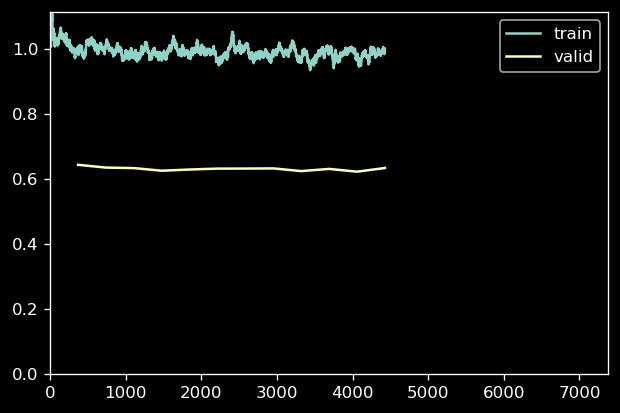

In [31]:
# learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.68)

# learn.fit_one_cycle(EPOCHS, slice(LR_CHOICE_UNFROZ),  wd=1e-2)

learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.2, wd=1e-2, reset_opt=True)
# fit_hump(learn, EPOCHS, lr_max=LR_CHOICE_UNFROZ, reset_opt=True)

print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
torch.cuda.reset_max_memory_allocated()

In [ ]:
learn.recorder.plot_sched()

<br>
<br>

<br>

# -------------------- TRAIN AGAIN -----------------

<br>

<br>
<br>

### Train again

In [ ]:
# save_model("test.pth", learn, learn.opt, with_opt=True)

In [ ]:
# learn = load_learner(f'../models/{RUN_NAME}.pkl', cpu=False)
#
    # RUN_NAME_OF_MODEL_TO_LOAD = '20210210-2234 - arch=tf_efficientnet_b4_ns - samples=1800 frozen=1 epochs=15 bs=12 res=460'
    # EPOCH_TO_LOAD = 9

# load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}_{EPOCH_TO_LOAD}.pth', learn, opt=ranger, with_opt=False)

# load_model(f'models/{RUN_NAME}_8.pth', learn, opt=ranger, with_opt=True)
# learn = load_learner(f'../models/{RUN_NAME}.pkl', cpu=False)
# load_model(f'test.pth', learn, opt=ranger, with_opt=True)

# load_model(f'models/20210213-2138 - arch=efficientnet_b3a - samples=1800 frozen=3 epochs=60 bs=32 res=400_9.pth', learn, opt=ranger, with_opt=True)

learn.dls = dls
learn.remove_cbs(cbs)
learn.add_cbs(cbs)

learn.opt.clear_state()


In [ ]:
learn.unfreeze()

In [ ]:
# learn.dls = dls_findlr
lr_min,lr_steep = learn.lr_find()
plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
# plt.axvline(LR_CHOICE/2, ls='--', color='yellow', label=f'LR_CHOICE/2={round(LR_CHOICE/2,6)}')
plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
plt.axvline(2e-5, ls='--', color='green', label=f'{round(2e-5,6)}')
plt.axvline(7e-5, ls='--', color='orange', label=f'{round(7e-5,6)}')

plt.legend()
plt.show()


learn.dls = dls
del dls_findlr
gc.collect()
torch.cuda.empty_cache()
gc.collect()


In [ ]:
EPOCHS = 20
LR_CHOICE_UNFROZ = 7e-3

In [ ]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

In [ ]:
# learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.68)

# learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.2, wd=0.1) # , reset_opt=True)
fit_hump(learn, EPOCHS, lr_max=LR_CHOICE_UNFROZ, reset_opt=False)

print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
torch.cuda.reset_max_memory_allocated()

<br>
<br>

## Persist the Model

In [ ]:
learn.export(f'../models/{RUN_NAME}.pkl')
print(f'Saved to: ../models/{RUN_NAME}.pkl')

# path = Path('../models')
# path.ls(file_exts='.pkl')

<br>
<br>

### Show some Results

In [ ]:
learn.show_results()


<br>
<hr>
<br>
<br>
<br>

# Validation Set (not test set) Analysis

<br>

### Plot Losses

In [ ]:
# learn.recorder.plot_loss()
# plt.ylabel('Loss')
# plt.xlabel('Batches Processed')

<br>

### Visualize with a confusion Matrix

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
interp.most_confused()[:10]

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

<br>

### Show the top 15 most error prone images

In [ ]:
interp.plot_top_losses(15, nrows=5)

<br>
<br>
<br>
<br>

# ----------------- Validation ------------

<br>
<br>

<br>

In [45]:
VALID_RESOLUTION = 400
VALID_BATCH_SIZE = 12

test_learn = learn

# load_learner('../models/{RUN_NAME}.pkl', cpu=False)
# load_model(f'models/{RUN_NAME_OF_MODEL_TO_LOAD}.pth', test_learn, opt=ranger, with_opt=True)


In [46]:
def get_train_aug_test(): return A.Compose([
            A.RandomResizedCrop(VALID_RESOLUTION,VALID_RESOLUTION, scale=(0.2, 1)),
            A.Transpose(p=0.7),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.7),
            A.HueSaturationValue(
                hue_shift_limit=0.3, 
                sat_shift_limit=0.3, 
                val_shift_limit=0.3, 
                p=0.7
            ),
            A.RandomBrightnessContrast(
                brightness_limit=(-0.2,0.2), 
                contrast_limit=(-0.2, 0.2), 
                p=0.7
            ),
            A.CoarseDropout(p=0.8, max_holes=20),
            A.Cutout(p=0.8, max_h_size=12, max_w_size=12),
            A.Sharpen(p=0.3, alpha=(0.1,0.3), lightness=(0.3, 0.9))
], p=1.0)



def get_valid_aug_test(): return A.Compose([
    A.Resize(VALID_RESOLUTION, VALID_RESOLUTION, p=1.0),
    A.OneOf([
        A.CenterCrop(VALID_RESOLUTION,VALID_RESOLUTION, always_apply=True),
#         A.Resize(VALID_RESOLUTION, VALID_RESOLUTION, p=1.0),
        A.RandomResizedCrop(VALID_RESOLUTION,VALID_RESOLUTION, scale=(0.2, 0.8), always_apply=True),

        ], p=0.9),
#         A.HueSaturationValue(
#             hue_shift_limit=0.2, 
#             sat_shift_limit=0.2, 
#             val_shift_limit=0.2, 
#             p=0.5
#             ),
#         A.RandomBrightnessContrast(
#             brightness_limit=(-0.15,0.15), 
#             contrast_limit=(-0.1, 0.2), 
#             p=0.5
#             ),
    A.Sharpen(p=0.7, alpha=(0.1, 0.3), lightness=(0.3, 0.9))
], p=1.0)

In [47]:
def get_test_fnames(path):
    retlist = []
    
    for l in test_flist.values():
        for f in l:
            retlist.append(f)
            
    return random.sample(retlist, len(retlist))


In [48]:


test_item_tfms = [AlbumentationsTransform(get_train_aug_test(), get_valid_aug_test())]





test_batch_tfms = [Normalize.from_stats(*imagenet_stats)]

test_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_test_fnames,
    get_y=parent_label, 
    item_tfms=test_item_tfms,
    batch_tfms=test_batch_tfms)
#     item_tfms=Resize(VALID_RESOLUTION, method='bilinear', pad_mode='zeros'), 
#     batch_tfms=[Normalize.from_stats(*imagenet_stats)])  #batch_tfms) #,

dls = test_db.dataloaders(get_test_fnames, bs=VALID_BATCH_SIZE)

test_dl = dls.test_dl(get_test_fnames('None'), with_labels=True)

####  Get the Inferrences on the Test Set

In [49]:
inputs, preds, targs, decoded, losses = test_learn.get_preds(dl=test_dl, with_input=True, with_decoded=True, with_loss=True, reorder=False)


In [50]:
interp = ClassificationInterpretation(dl=test_dl, inputs=inputs, preds=preds, targs=targs, decoded=decoded, losses=losses )

<br>

### Visualize with a confusion Matrix

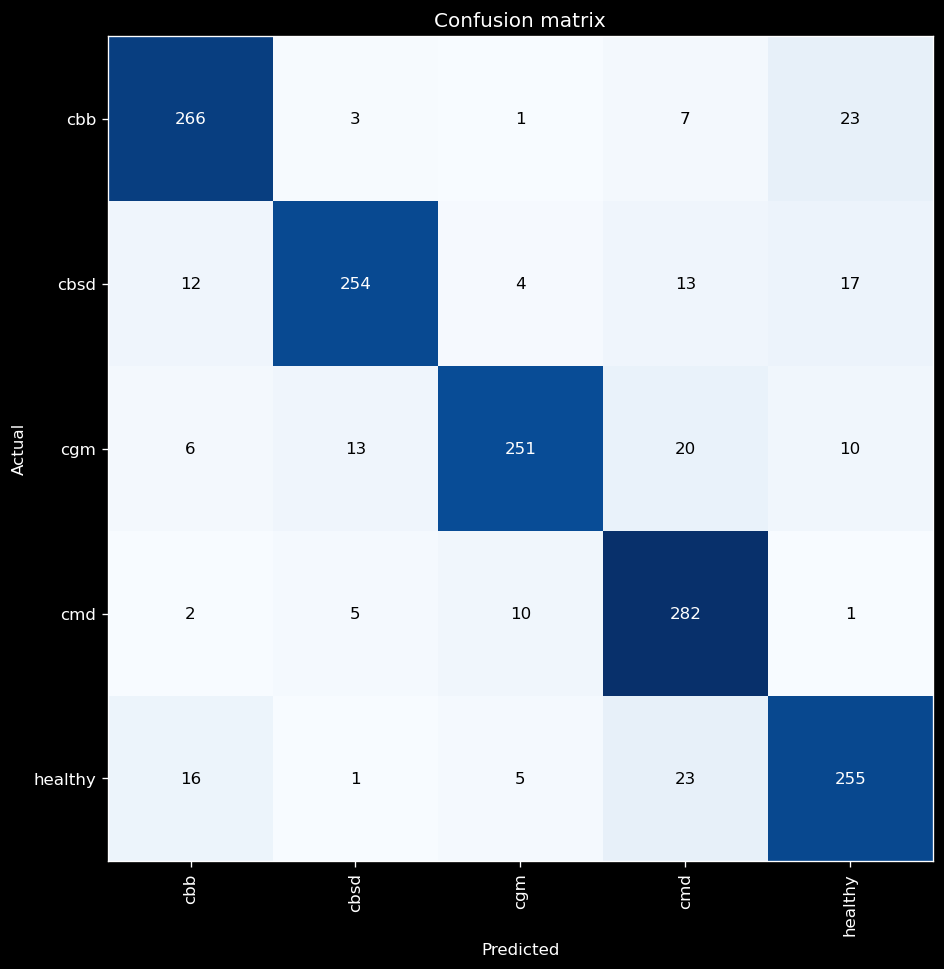

In [51]:
interp.plot_confusion_matrix(figsize=(8,8))

In [52]:
interp.most_confused()[:10]

[('cbb', 'healthy', 23),
 ('healthy', 'cmd', 23),
 ('cgm', 'cmd', 20),
 ('cbsd', 'healthy', 17),
 ('healthy', 'cbb', 16),
 ('cbsd', 'cmd', 13),
 ('cgm', 'cbsd', 13),
 ('cbsd', 'cbb', 12),
 ('cgm', 'healthy', 10),
 ('cmd', 'cgm', 10)]

<br>
<br>

## Classification Report

In [53]:
interp.print_classification_report()

              precision    recall  f1-score   support

         cbb       0.88      0.89      0.88       300
        cbsd       0.92      0.85      0.88       300
         cgm       0.93      0.84      0.88       300
         cmd       0.82      0.94      0.87       300
     healthy       0.83      0.85      0.84       300

    accuracy                           0.87      1500
   macro avg       0.88      0.87      0.87      1500
weighted avg       0.88      0.87      0.87      1500



In [54]:
interp.plot_top_losses(k=15)

## Archive this version of the notebook

In [ ]:
import os
import shutil

# Allow Jupyter the opportunity to autosave
!sleep 20
# time = '20210122-2356'
# copy the notebook file - the prefix links it to the saved model
shutil.copyfile('DenseNet Cassava Disease Classification.ipynb', f'.Archive/{time} - DenseNet Cassava Disease Classification.ipynb')

## Infer on the Kaggle provided test set

In [ ]:
predstta, targstta = test_learn.tta(dl=test_dl, n=5)  #, use_max=False, beta=0.1)
# print(classification_report(sample_df.iloc[:,0], preds.argmax(dim=-1).numpy()))  # TTA

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(predstta.argmax(dim=-1), targstta))

# FIND ALL WRONG FILES

In [ ]:
def get_test_fnames(path):
    return all_files

test_item_tfms = [AlbumentationsTransform(get_train_aug_test(), get_valid_aug_test())]
test_batch_tfms = [Normalize.from_stats(*imagenet_stats)]

test_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_test_fnames,
    get_y=parent_label, 
    item_tfms=test_item_tfms,
    batch_tfms=test_batch_tfms)

dls = test_db.dataloaders(get_test_fnames, bs=VALID_BATCH_SIZE)

test_dl = dls.test_dl(get_test_fnames('None'), with_labels=True)

allpreds, alltargs, alldecoded = test_learn.get_preds(dl=test_dl, with_decoded=True)

In [ ]:
inacc_flist = []

for i in range(len(alltargs)):
    if int(alltargs[i]) != int(alldecoded[i]):
        inacc_flist.append(test_dl.items[i])
        
print(f'Number of inaccurate inferrences: {len(inacc_flist)}')
print(f'Percent Accurate:  {1 - (len(inacc_flist) / len(alltargs))}')

        

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print(classification_report(alltargs, allpreds.argmax(dim=-1)))
confusion_matrix(alltargs, allpreds.argmax(dim=-1))

In [ ]:
import pickle
with open(f"INACCFLIST_{RUN_NAME_OF_MODEL_TO_LOAD}.p", "wb") as pfile:
    pickle.dump(inacc_flist, pfile)